In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow
from keras.applications.vgg16 import VGG16
from keras.applications import DenseNet201
from keras.applications import ResNet50V2
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [5]:
RANDOM_STATE = 0

In [6]:
path_to_cr_data = "/content/drive/MyDrive/Capstone"
img_dirs = []
for entry in os.scandir(path_to_cr_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

img_dirs

['/content/drive/MyDrive/Capstone/Indira_Nooyi',
 '/content/drive/MyDrive/Capstone/Dalai_Lama',
 '/content/drive/MyDrive/Capstone/Melinda_Gates',
 '/content/drive/MyDrive/Capstone/Virat_Kohli',
 '/content/drive/MyDrive/Capstone/Bill_Gates',
 '/content/drive/MyDrive/Capstone/Vikas_Khanna',
 '/content/drive/MyDrive/Capstone/Narendra_Modi',
 '/content/drive/MyDrive/Capstone/Anushka_Sharma',
 '/content/drive/MyDrive/Capstone/Barack_Obama',
 '/content/drive/MyDrive/Capstone/Sundar_Pichai']

In [7]:
celebrity_file_names_dict={}
for img_dir in img_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list

In [8]:
for k, v in celebrity_file_names_dict.items():
  print(k, len(v))

Indira_Nooyi 256
Dalai_Lama 231
Melinda_Gates 394
Virat_Kohli 276
Bill_Gates 217
Vikas_Khanna 294
Narendra_Modi 224
Anushka_Sharma 258
Barack_Obama 338
Sundar_Pichai 228


In [9]:
img_list_height = []
img_list_width = []
for k, v in celebrity_file_names_dict.items():
    for im in v:
        img = cv2.imread(im)
        img_list_height.append(img.shape[0])
        img_list_width.append(img.shape[1])

In [10]:
IMG_SIZE = [224,224]

In [11]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'Indira_Nooyi': 0,
 'Dalai_Lama': 1,
 'Melinda_Gates': 2,
 'Virat_Kohli': 3,
 'Bill_Gates': 4,
 'Vikas_Khanna': 5,
 'Narendra_Modi': 6,
 'Anushka_Sharma': 7,
 'Barack_Obama': 8,
 'Sundar_Pichai': 9}

In [12]:
inv_dict = dict(zip(class_dict.values(), class_dict.keys()))
inv_dict

{0: 'Indira_Nooyi',
 1: 'Dalai_Lama',
 2: 'Melinda_Gates',
 3: 'Virat_Kohli',
 4: 'Bill_Gates',
 5: 'Vikas_Khanna',
 6: 'Narendra_Modi',
 7: 'Anushka_Sharma',
 8: 'Barack_Obama',
 9: 'Sundar_Pichai'}

In [13]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        X.append(img)
        y.append(class_dict[celebrity_name])

In [14]:
X_train_temp, X_test_temp, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=RANDOM_STATE)

In [15]:
Total_Pixels = 0
B_sum  = 0
G_sum = 0
R_sum = 0

for img in X_train_temp:
    Total_Pixels = Total_Pixels  + img.shape[0]*img.shape[1]
    (B,G,R) = cv2.split(img)
    B_sum = B_sum + B.sum()
    G_sum = G_sum + G.sum()
    R_sum = R_sum + R.sum()


B_mean = B_sum/Total_Pixels
G_mean = G_sum/Total_Pixels
R_mean = R_sum/Total_Pixels

In [16]:
X_train = []
for img in X_train_temp:
    if img is not None:
        img_resized = cv2.resize(img, (IMG_SIZE[0], IMG_SIZE[1]))
        (B,G,R) = cv2.split(img_resized)
        B = B - B_mean
        G = G - G_mean
        R = R - R_mean
        img_preprocessed = cv2.merge([B, G, R])
        X_train.append(img_preprocessed)

In [17]:
X_test = []
for img in X_test_temp:
    if img is not None:
        img_resized = cv2.resize(img, (IMG_SIZE[0], IMG_SIZE[1]))
        (B,G,R) = cv2.split(img_resized)
        B = B - B_mean
        G = G - G_mean
        R = R - R_mean
        img_preprocessed = cv2.merge([B, G, R])
        X_test.append(img_preprocessed)

In [18]:
del X_train_temp, X_test_temp, B, G, R, B_mean, G_mean, R_mean, img_resized, img_preprocessed, Total_Pixels

In [19]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [20]:
INPUT_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], 3)
N_CLASSES = 10
OPTIMIZER = Adam(learning_rate=0.0001)
LOSS_FUNC = 'sparse_categorical_crossentropy'
METRICS = ['accuracy']
EPOCHS = 10
BATCH_SIZE = 32
OUTPUT_ACTIVATION = 'softmax'

In [21]:
def create_model_resnet(input_shape, n_classes, optimizer, loss_func, metrics, output_activation, freeze):

    conv_base = ResNet50V2(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)

    if freeze > 0:
        for layer in conv_base.layers[:-freeze]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False


    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation=output_activation)(top_model)


    model = Model(inputs=conv_base.input, outputs=output_layer)

    model.compile(optimizer=optimizer,
                  loss=loss_func,
                  metrics=metrics)

    return model

In [22]:
def training_accuracy_plot(history,model):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()

In [23]:
def training_loss_plot(history,model):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

In [24]:
resnet_model = create_model_resnet(INPUT_SHAPE, N_CLASSES, OPTIMIZER, LOSS_FUNC, METRICS, OUTPUT_ACTIVATION,0)

94668760/94668760 [==============================] - 1s 0us/step


In [25]:
resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

In [26]:
history_resnet = resnet_model.fit(X_train, y_train, batch_size=BATCH_SIZE, validation_split=0.15,epochs=EPOCHS, shuffle=True)

Epoch 1/10
58/58 [==============================] - 29s 255ms/step - loss: 1069.6432 - accuracy: 0.3960 - val_loss: 227.2218 - val_accuracy: 0.5613
Epoch 2/10
58/58 [==============================] - 12s 202ms/step - loss: 152.6365 - accuracy: 0.6024 - val_loss: 87.2539 - val_accuracy: 0.6288
Epoch 3/10
58/58 [==============================] - 11s 197ms/step - loss: 62.9304 - accuracy: 0.6912 - val_loss: 57.2139 - val_accuracy: 0.6472
Epoch 4/10
58/58 [==============================] - 12s 200ms/step - loss: 40.4618 - accuracy: 0.7291 - val_loss: 33.5473 - val_accuracy: 0.7086
Epoch 5/10
58/58 [==============================] - 12s 202ms/step - loss: 20.8671 - accuracy: 0.7741 - val_loss: 24.3732 - val_accuracy: 0.7055
Epoch 6/10
58/58 [==============================] - 12s 204ms/step - loss: 14.8443 - accuracy: 0.7703 - val_loss: 21.9564 - val_accuracy: 0.6871
Epoch 7/10
58/58 [==============================] - 12s 206ms/step - loss: 10.0434 - accuracy: 0.7784 - val_loss: 10.4835 - va

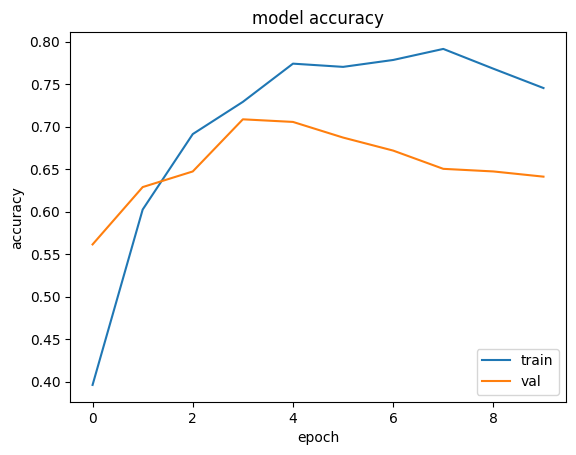

In [27]:
training_accuracy_plot(history_resnet,resnet_model)

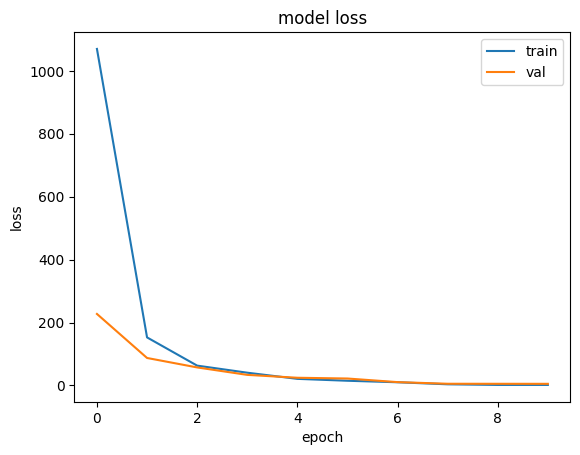

In [28]:
training_loss_plot(history_resnet,resnet_model)

In [29]:
test_loss, test_accuracy = resnet_model.evaluate(X_test, y_test)
test_accuracy_resnet = test_accuracy*100

17/17 [==============================] - 2s 103ms/step - loss: 4.2460 - accuracy: 0.6967


In [30]:
y_pred = resnet_model.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]

17/17 [==============================] - 3s 106ms/step


In [31]:
print("Classification Report: \n", classification_report(y_test, y_pred_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.71      0.80        49
           1       0.44      0.64      0.52        44
           2       0.69      0.85      0.76        74
           3       0.91      0.65      0.76        63
           4       0.61      0.70      0.65        43
           5       0.70      0.46      0.55        57
           6       0.88      0.64      0.74        45
           7       0.75      0.55      0.63        44
           8       0.62      0.77      0.69        71
           9       0.72      0.89      0.79        54

    accuracy                           0.70       544
   macro avg       0.72      0.69      0.69       544
weighted avg       0.72      0.70      0.70       544



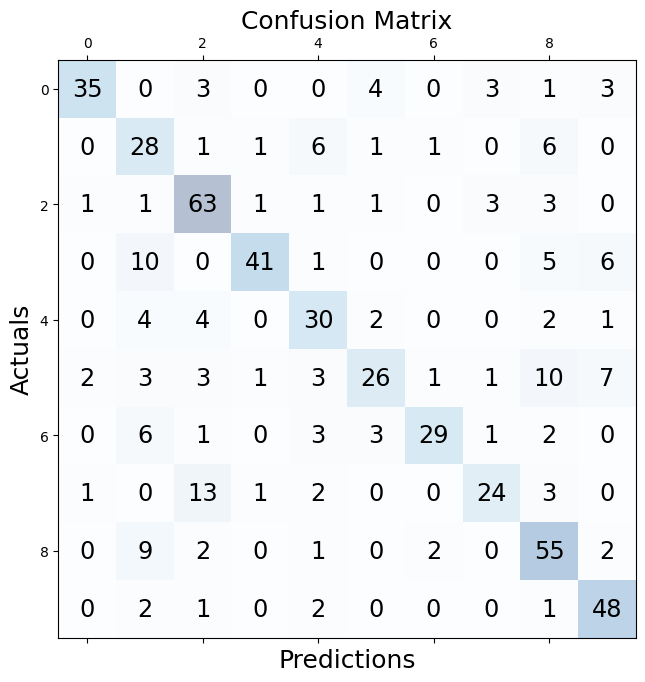

In [32]:
conf_matrix=confusion_matrix(y_test, y_pred_classes)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()